In [1]:
import networkx as nx
from hierarchy_pos import hierarchy_pos
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import pandas as pd
import numpy as np
import itertools
import os

In [21]:
L = 2

In [22]:
color_iterator = itertools.cycle(sns.color_palette())
df_hier = pd.read_csv("labels.txt")
df_hier[f"l{L+1}"] = np.ones(df_hier.shape[0], dtype=int)
L=L+1
labels = df_hier["tissue"].unique()

#create a color palette with the same number of colors as unique values in the Source column
network_pal = sns.color_palette('husl',n_colors=len(labels))
network_pal = [next(color_iterator) for label in labels]

#Create a dictionary where the key is the category and the values are the
#colors from the palette we just created
network_lut = dict(zip(labels, network_pal))

In [23]:
def get_fracs(node):
    node = node.split("_")
    uniques = np.unique(df_hier[df_hier[node[0]]==int(node[1])]["tissue"], return_counts=True)
    return uniques[1], [network_lut[label] for label in uniques[0]]

In [24]:
hierarchy = nx.Graph()

In [25]:
# add nodes
for l in range(L+1):
    if l==0:
        continue
    hierarchy.add_nodes_from([f"l{l}_{n}" for n in df_hier[f"l{l}"].unique()])

In [26]:
# add edges
for l in range(L+1):
    if l<=1:
        continue
    for node in df_hier[f"l{l}"].unique():
        hierarchy.add_edges_from([(f"l{l}_{node}", f"l{l-1}_{low_node}") for low_node in df_hier[df_hier[f"l{l}"]==node][f"l{l-1}"].unique()])
if not nx.is_tree(hierarchy):
    raise ValueError("Graph is not a tree!")

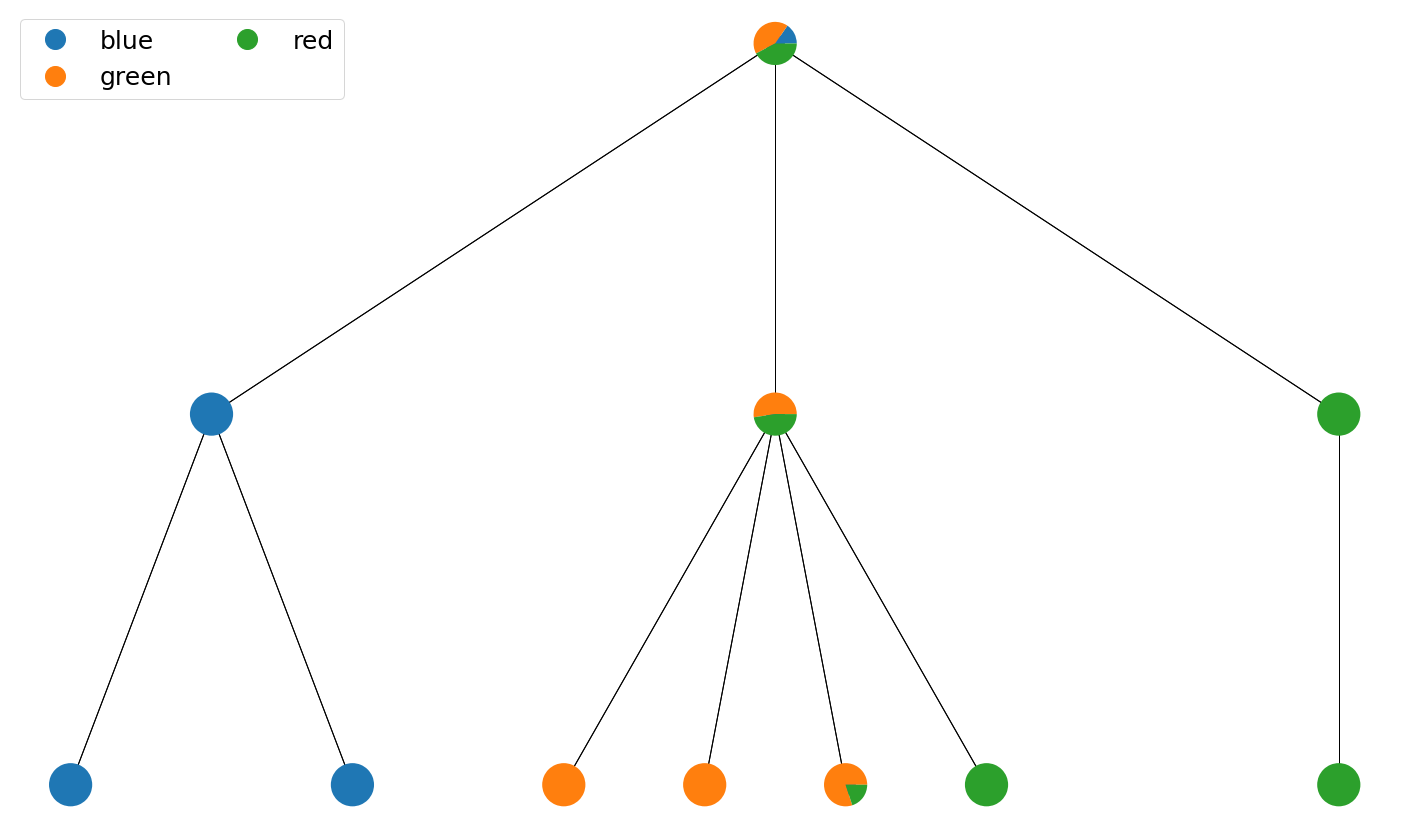

In [27]:
pos = hierarchy_pos(hierarchy, root=f"l{L}_1")
#pos = nx.spring_layout(hierarchy)
fig, ax = plt.subplots(figsize=(25,15))

nx.draw(hierarchy, pos=pos, ax=ax)
nx.draw_networkx_nodes(hierarchy,pos)
nx.draw_networkx_edges(hierarchy, pos=pos, ax=ax)
#nx.draw_networkx_labels(hierarchy, pos=pos, ax=ax, font_size=25)

trans=ax.transData.transform
trans2=fig.transFigure.inverted().transform

piesize=0.05
p2=piesize/2.0
for n in hierarchy:
    xx,yy=trans(pos[n]) # figure coordinates
    xa,ya=trans2((xx,yy)) # axes coordinates
    a = plt.axes([xa-p2,ya-p2, piesize, piesize])
    a.set_aspect('equal')
    fracs, colors = get_fracs(n)
    a.pie(fracs, colors=colors)
    
legend_elements = [Line2D([0], [0], 
                          marker='o', 
                          ms = 20,
                          lw = 0,
                          color=network_lut[label], 
                          label=label,
                          markerfacecolor=network_lut[label],
                          markersize=15) for label in labels]

ax.legend(handles=legend_elements, fontsize=25, ncol=2, loc='upper left')
    
plt.show()
fig.savefig("cluster_network.pdf")